In [1]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from keras.preprocessing import image 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
from tensorflow.image import rgb_to_grayscale

Using TensorFlow backend.


## NN for Normal vs NonNormal

In [2]:
def normal_nonnormal(x): 
    if x == 'Normal': 
        return x 
    else: 
        return 'Non-Normal'

df = pd.read_csv('../CombinedImages/CombinedUpdated.csv')
na_fill = {'VirusCategory1': 'Normal'}
df = df.fillna(value = na_fill)

df.VirusCategory1 = df.VirusCategory1.map(normal_nonnormal)
df = df.join(pd.get_dummies(df.VirusCategory1.values, prefix = 'type'))
columns_include = ['Normal']
df = df[['ImagePath', 'VirusCategory1'] + [f'type_{i}' for i in columns_include]]


In [3]:
df

,ImagePath,VirusCategory1,type_Normal
0,IM-0128-0001.jpeg,Normal,1
1,IM-0127-0001.jpeg,Normal,1
2,IM-0125-0001.jpeg,Normal,1
3,IM-0122-0001.jpeg,Normal,1
4,IM-0119-0001.jpeg,Normal,1
...,...,...,...
6472,covid-19-caso-95-2-16.png,Non-Normal,0
6473,covid-19-caso-95-3-14.png,Non-Normal,0
6474,covid-19-caso-95-4-12.png,Non-Normal,0
6475,covid-19-caso-99-1-19.png,Non-Normal,0


In [4]:
X = df[['ImagePath', 'VirusCategory1']]
y = df[[f'type_{i}' for i in columns_include]]

x_train, x_test, y_train, y_test = train_test_split(X,y, random_state = 10, stratify = X.VirusCategory1.values,
                                                   train_size = .95)

x_train = x_train.drop('VirusCategory1', axis = 1)
x_test = x_test.drop('VirusCategory1', axis = 1)

In [5]:
#print(len(df[df['type_Normal']==1]), len(df[df['type_Normal']==0]))

In [6]:
def get_image_value(path, img_type): 
    img = image.load_img(path, target_size = (28,28,3))
    img = image.img_to_array(img)
    if img_type == 'grey':
        img = np.dot(img[...,:3], [.2989,.5870,.1140])
    return img/255


def get_data(df, img_type): 
    from tqdm import tqdm
    img_list = [] 
    for path in tqdm(df.ImagePath.values):
        path = f'../CombinedImages/all/{path}'
        img_list.append(get_image_value(path, img_type)) 
    return np.array(img_list).squeeze()
img_type = 'normal'
x_test = get_data(x_test, img_type)
x_train = get_data(x_train, img_type)


100%|██████████| 6153/6153 [01:30<00:00, 68.27it/s]


In [ ]:
#plt.imshow(x_test[0], cmap = plt.get_cmap('gray'))

In [ ]:
import pickle 
# pickle.dump(x_train, open('picklesNorm/x_train_normal.p', 'wb'), protocol = 2)
# pickle.dump(x_test, open('picklesNorm/x_test_normal.p', 'wb'))

# pickle.dump(x_train, open('picklesNorm/x_train_grey.p', 'wb'))
# pickle.dump(x_test, open('picklesNorm/x_test_grey.p', 'wb'))

# pickle.dump(y_train, open('picklesNorm/y_train.p', 'wb'))
# pickle.dump(y_test, open('picklesNorm/y_test.p', 'wb'))

In [ ]:
assert False

In [7]:
def get_image_value(path, img_type): 
    img = image.load_img(path, target_size = (28,28,3))
    img = image.img_to_array(img)
    if img_type == 'grey':
        img = np.dot(img[...,:3], [.2989,.5870,.1140])
    return img/255

img_type = 'normal'


In [8]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten 
from keras.layers import Conv2D, MaxPooling2D 
from keras import regularizers
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from keras.preprocessing import image 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
from tensorflow.image import rgb_to_grayscale
import pickle
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

In [9]:
def get_conv_model_normal(img_type):
    if img_type == 'normal': 
        inp_shape = (28,28,3)
    else: 
        inp_shape = (28,28, 1)
    act = 'sigmoid'
    drop = .25 
    kernal_reg = regularizers.l2(.001)
    dil_rate = 2
    adam = Adam(.001)
    
    model = Sequential() 
    
    model.add(Conv2D(128, kernel_size=(3,3),activation=act, input_shape = inp_shape, 
                     kernel_regularizer = kernal_reg, kernel_initializer = 'he_uniform', padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(128, (3, 3), activation=act, kernel_regularizer = kernal_reg, dilation_rate = dil_rate, 
                     kernel_initializer = 'he_uniform', padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
   
    model.add(Flatten())
    model.add(Dropout(drop))

    model.add(Dense(512, activation='relu'))
    model.add(Dropout(drop))

    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    return model 
# def get_conv_model_normal(img_type):
#     if img_type == 'normal': 
#         inp_shape = (28,28,3)
#     else: 
#         inp_shape = (28,28, 1)
#     drop = .25 
#     kernal_reg = regularizers.l2(.001)
#     dil_rate = 2
#     model = Sequential() 
    
#     model.add(Conv2D(128, kernel_size=(3,3),activation='sigmoid', input_shape = inp_shape, 
#                      kernel_regularizer = kernal_reg, kernel_initializer = 'he_uniform', padding = 'same'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))


#     model.add(Conv2D(128, (1, 1), activation='sigmoid', kernel_regularizer = kernal_reg, dilation_rate = dil_rate, 
#                      kernel_initializer = 'he_uniform', padding = 'same'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
    
# #     model.add(Conv2D(128, (1, 1), activation='relu', kernel_regularizer = kernal_reg, dilation_rate = dil_rate))
# #     model.add(MaxPooling2D(pool_size=(2, 2)))
    
#     model.add(Flatten())
#     model.add(Dropout(drop))
    
#     model.add(Dense(512, activation='relu'))
#     model.add(Dropout(drop))

#     model.add(Dense(2, activation='sigmoid'))
    
#     model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
#     return model 

In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


# def get_samples_norm(img_type): 
#     x_train = pickle.load(open(f'picklesNorm/x_train_{img_type}.p', 'rb'))
#     x_test = pickle.load(open(f'picklesNorm/x_test_{img_type}.p', 'rb'))
#     y_train = pickle.load(open(f'picklesNorm/y_train.p', 'rb'))
#     y_test = pickle.load(open(f'picklesNorm/y_test.p', 'rb'))
#     return x_train, x_test, y_train, y_test
# x_train, x_test, y_train, y_test = get_samples_norm(img_type)
# print(x_train.shape)


if img_type == 'grey': 
    x_train = x_train.reshape(len(x_train), 28, 28, 1)
    x_test = x_test.reshape(len(x_test), 28, 28, 1)
early_stopping = EarlyStopping(monitor='val_loss', verbose = 1, patience=5)
model_checkpoint = ModelCheckpoint('models/Tester-NormalModelCheckpointWeights.h5', verbose = 1, save_best_only=True)

epochs = 10
batch_size = 32
normal_model = get_conv_model_normal(img_type)
normal_history = normal_model.fit(x_train, y_train, epochs = epochs, batch_size = batch_size, 
         callbacks = [early_stopping, model_checkpoint], validation_data = (x_test, y_test), verbose= 1)

Epoch 1/10
193/193 [==============================] - ETA: 0s - loss: 0.7696 - accuracy: 0.8981
Epoch 00001: val_loss improved from inf to 0.47057, saving model to models/Tester-NormalModelCheckpointWeights.h5
193/193 [==============================] - 23s 119ms/step - loss: 0.7696 - accuracy: 0.8981 - val_loss: 0.4706 - val_accuracy: 0.9012
Epoch 2/10
193/193 [==============================] - ETA: 0s - loss: 0.3344 - accuracy: 0.9545
Epoch 00002: val_loss improved from 0.47057 to 0.23124, saving model to models/Tester-NormalModelCheckpointWeights.h5
193/193 [==============================] - 22s 116ms/step - loss: 0.3344 - accuracy: 0.9545 - val_loss: 0.2312 - val_accuracy: 0.9753
Epoch 3/10
192/193 [============================>.] - ETA: 0s - loss: 0.2210 - accuracy: 0.9587
Epoch 00003: val_loss improved from 0.23124 to 0.16246, saving model to models/Tester-NormalModelCheckpointWeights.h5
193/193 [==============================] - 22s 115ms/step - loss: 0.2209 - accuracy: 0.9587 - 

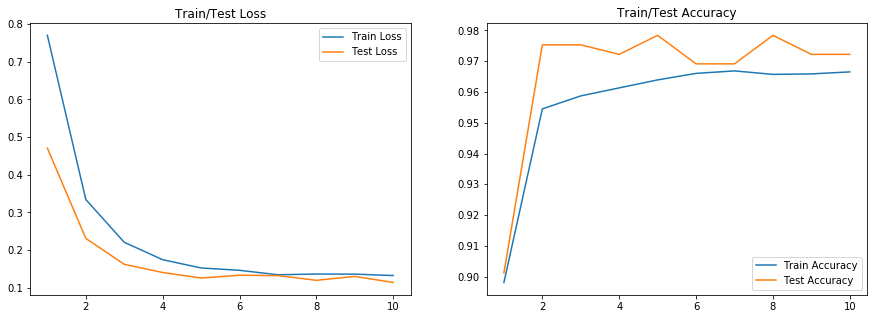

In [11]:
train_loss = normal_history.history['loss']
train_acc = normal_history.history['accuracy']
test_loss = normal_history.history['val_loss']
test_acc = normal_history.history['val_accuracy']
epochs = [i for i in range(1, len(test_acc)+1)]

fig, ax = plt.subplots(1,2, figsize = (15,5))
ax[0].plot(epochs, train_loss, label = 'Train Loss')
ax[0].plot(epochs, test_loss, label = 'Test Loss')
ax[0].set_title('Train/Test Loss')
ax[0].legend()

ax[1].plot(epochs, train_acc, label = 'Train Accuracy')
ax[1].plot(epochs, test_acc, label = 'Test Accuracy')
ax[1].set_title('Train/Test Accuracy')
ax[1].legend()

In [42]:
normal_model = get_conv_model_normal(img_type)
normal_model.load_weights('models/Tester-NormalModelCheckpointWeights.h5')
tester_img = get_image_value('TestImages/Normal6.jpg', img_type)
if img_type == 'grey': 
    tester_img = np.reshape(tester_img, (1,28,28,1))
else:
    tester_img = np.reshape(tester_img, (1,28,28,3))
normal_predict = normal_model.predict(tester_img).squeeze()
print(normal_predict)
if normal_predict < .5: 
    print('Non-Normal')
else: 
    print('Normal')



0.021260649
Non-Normal


In [ ]:
test_predict = normal_model.predict(x_test.reshape(len(x_test), 28, 28, 3))
print(y_test, test_predict)
print(confusion_matrix(y_test, test_predict))

In [ ]:
assert False

### Test on Random Images

['Normal', 'COVID-19', 'Bacterial', 'Fungal', 'SARS']
['Normal', 'COVID-19', 'Bacterial']